# CIS545: Final Project - CORD-19 Dataset
## Justin Choi
## TA: Hoyt Gong

Hi there! For this project, I opted to use the COVID-19 research challenge dataset, which they named "CORD-19" (I promise, the title wasn't a typo haha), and below you'll see the respective EDA and modeling I've done for the dataset! Hope you enjoy ~


In [1]:
import pandas as pd 
import numpy as np 
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import glob, os
import json
import nltk


# The Data 
Thanks to all the ~ useful ~ skills we've picked up over the course of this semester, we'll start with everyone's favorite tedious, time-consuming task - data cleaning! woo hoooooOOOOooOo who doesn't lüv missing values and weird formatting. 

Most of the work in this section was basically just finding good ways to extract the text from the json format to put into the dataframe, and then proceeded to clean it using basic `pandas` and the `langdetect` package in order to filter out any articles not in English in order to standardize the data and simplify visualization/processing/modeling later on! 

In [2]:
metadata_df = pd.read_csv('./CORD-19-research-challenge/metadata.csv')

# Import all the json files
cord_19_folder = './CORD-19-research-challenge/'
list_of_files = []; # only going to take those from pdf_json! not pmc_json
for root, dirs, files in os.walk(cord_19_folder):
    for name in files:
        if (name.endswith('.json')):
            full_path = os.path.join(root, name)
            list_of_files.append(full_path)
sorted(list_of_files)
print('done')

# ALTERNATE

# all_json = glob.glob(f'{cord_19_folder}/**/*.json', recursive=True)
# len(all_json)


done


In [3]:
class JsonReader:
    def __init__(self, file_path):
        with open(file_path) as file: 
            content = json.load(file)
            # start to insert body text 
            self.paper_id = content['paper_id']
            self.body_text = [] 
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.body_text[:500]}...'

random_json = list_of_files[47404]
sample_article = JsonReader(random_json)
print(sample_article)

PMC1403753: Migration, transmigration, [1] return migration, and remigration constitute defining elements of the current and future world order. More than 700 million people (including visitors on business or personal/family trips) traverse nation-state borders annually [2,3] and one million per week move between the global South and the global North [4]. The enormity of contemporary transnational mobility is illustrated by the case of Australia. In the past half century, Australia's "resident population ha...


In [4]:
input = {'paper_id': [], 'doi':[],  'title': [], 'abstract': [], 'body_text': [], 'authors': [], 'journal': []}

for index, entry in enumerate(list_of_files):
    if index % (len(list_of_files) // 10) ==    0:
        print(f'Processing {index} of {len(list_of_files)}')
    try: 
        article = JsonReader(entry)
    except Exception as e: 
        continue #means that we don't have a valid file format  
    
    metadata = metadata_df.loc[metadata_df['sha'] == article.paper_id]
    if len(metadata) == 0:
        continue # no such metadata for paper in our csv, skip

    input['body_text'].append(article.body_text)
    input['paper_id'].append(article.paper_id)

    # add in metadata 
    title = metadata['title'].values[0] 
    doi = metadata['doi'].values[0] 
    abstract = metadata['abstract'].values[0] 
    authors = metadata['authors'].values[0] 
    journal = metadata['journal'].values[0] 

    input['title'].append(title)
    input['doi'].append(doi)
    input['abstract'].append(abstract)
    input['authors'].append(authors)
    input['journal'].append(journal)



Processing 0 of 59311
Processing 5931 of 59311
Processing 11862 of 59311
Processing 17793 of 59311
Processing 23724 of 59311
Processing 29655 of 59311
Processing 35586 of 59311
Processing 41517 of 59311
Processing 47448 of 59311
Processing 53379 of 59311
Processing 59310 of 59311


In [22]:
covid_df = pd.DataFrame(input, columns=['paper_id', 'doi', 'title', 'abstract', 'body_text', 'authors', 'journal'])
print('finished creating dataframe from input dictionary')
rows, cols = covid_df.shape
print(f'number of rows: {rows}')
covid_df.info()

finished creating dataframe from input dictionary
number of rows: 36009
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36009 entries, 0 to 36008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   36009 non-null  object
 1   doi        35672 non-null  object
 2   title      35973 non-null  object
 3   abstract   31675 non-null  object
 4   body_text  36009 non-null  object
 5   authors    35413 non-null  object
 6   journal    34277 non-null  object
dtypes: object(7)
memory usage: 1.9+ MB


In [23]:
covid_df.dropna(inplace=True)
print('finished dropping articles with null abstracts/body text/titles')
rows, cols = covid_df.shape
print(f'number of rows: {rows}')

finished dropping articles with null abstracts/body text/titles
number of rows: 29600


In [24]:
covid_df['abstract_word_count'] = covid_df['abstract'].apply(lambda x : len(x.strip().split()))
covid_df['body_word_count'] = covid_df['body_text'].apply(lambda x : len(x.strip().split()))
covid_df['body_unique_count'] = covid_df['body_text'].apply(lambda x : len(set(x.strip().split())))


In [25]:
# visualiation check to see if data is finished being cleaned 
covid_df.head()


,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count
0,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,10.1080/14787210.2017.1271712,Update on therapeutic options for Middle East ...,Introduction: The Middle East Respiratory Synd...,The Middle East respiratory syndrome coronavir...,"Al-Tawfiq, Jaffar A.; Memish, Ziad A.",Expert Rev Anti Infect Ther,174,2748,996
1,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,10.1093/cid/ciaa256,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...","Bryson-Cahn, Chloe; Duchin, Jeffrey; Makarewic...",Clin Infect Dis,50,944,486
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,10.1016/b978-0-12-800049-6.00293-6,Evolutionary Medicine IV. Evolution and Emerge...,Abstract This article discusses how evolutiona...,The evolutionary history of humans is characte...,"Scarpino, S.V.",Encyclopedia of Evolutionary Biology,72,2884,1091
3,6599ebbef3d868afac9daa4f80fa075675cf03bc,10.1016/j.enpol.2008.08.029,International aviation emissions to 2025: Can ...,Abstract International aviation is growing rap...,"Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew; Wallace, Lailey",Energy Policy,137,5838,1587
5,44290ff75bad8ffaf5d3028420739ce7b08dc2a9,10.1093/jac/dkp502,Inhibition of enterovirus 71 replication and t...,OBJECTIVES: Enterovirus 71 (EV71) causes serio...,Enteroviruses are members of the family Picorn...,"Hung, Hui-Chen; Chen, Tzu-Chun; Fang, Ming-Yu;...",J Antimicrob Chemother,260,3121,1064


In [26]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29600 entries, 0 to 36008
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             29600 non-null  object
 1   doi                  29600 non-null  object
 2   title                29600 non-null  object
 3   abstract             29600 non-null  object
 4   body_text            29600 non-null  object
 5   authors              29600 non-null  object
 6   journal              29600 non-null  object
 7   abstract_word_count  29600 non-null  int64 
 8   body_word_count      29600 non-null  int64 
 9   body_unique_count    29600 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.5+ MB


In [27]:
#check to see if there are duplicates
covid_df['abstract'].describe()

count       29600
unique      29543
top       Unknown
freq           21
Name: abstract, dtype: object

In [28]:
covid_df.drop_duplicates(subset=['abstract', 'body_text'], inplace=True)

In [29]:
covid_df['abstract'].describe()

count       29597
unique      29543
top       Unknown
freq           21
Name: abstract, dtype: object

In [30]:
covid_df['body_text'].describe()

count                                                 29597
unique                                                29591
top       Swollen head syndrome (SHS) in avian species w...
freq                                                      2
Name: body_text, dtype: object

In [31]:
covid_df.describe()

,abstract_word_count,body_word_count,body_unique_count
count,29597.000000,29597.000000,29597.000000
mean,194.711356,4560.325878,1425.199007
std,151.302225,3528.817632,748.579044
min,1.000000,2.000000,2.000000
25%,140.000000,2705.000000,989.000000
50%,191.000000,3847.000000,1288.000000
75%,243.000000,5533.000000,1695.000000
max,18000.000000,171948.000000,25156.000000


In [67]:
from langdetect import detect
from tqdm import tqdm

languages = [] # make list that you can port directly into covid_df as column

for i in tqdm(range(len(covid_df))):
    row_text = covid_df.iloc[i]['body_text'].split(" ") 
    lang = 'en' # set default lang to be english 

    # try to just use the intro 25 words to detect language
    try:
        if (len(row_text)) > 125: 
            lang = detect(" ".join(row_text[:125]))
        elif(len(row_text)) > 0:
            lang = detect(" ".join(row_text))
    except Exception as e: # if body doesn't work, let's try abstract
        try: 
            lang = detect(covid_df.iloc(i)['abstract'].split())
        except Exception as e:
            lang = 'dunno'
            continue
    finally:
        languages.append(lang)
        

100%|██████████| 29025/29025 [03:05<00:00, 156.11it/s]


In [68]:
lang_array = np.asarray(languages)
covid_df['language'] = lang_array
lang_dict = {}
for language in lang_array:
    if language in lang_dict:
        lang_dict[language] += 1
    else: 
        lang_dict[language] = 1
lang_dict

{'en': 29010, 'es': 6, 'fr': 8, 'cy': 1}

In [73]:
# test to see if languages were detected correctly
covid_df[covid_df['language'] == 'es']

,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count,language
4161,3ad5111b29bd04ad0254298edf207d587b6803b6,10.1016/j.rce.2015.04.001,Utilización adecuada del lenguaje médico: prin...,Resumen El lenguaje médico debe caracterizarse...,"quality texts, critical dictionaries of questi...","Aleixandre-Benavent, R.; Valderrama Zurián, J....",Revista Clínica Española,255,2266,1041,es
8512,28f309f78ae68a7ad40bf2fb1b4cebece70c36e1,10.1016/j.arbres.2015.02.015,Revisión sobre las infecciones no bacterianas ...,Resumen Aunque las bacterias son los principal...,Ribavirin has been used in children with syncy...,"Galván, José María; Rajas, Olga; Aspa, Javier",Archivos de Bronconeumología,499,3194,1294,es
9476,31105078a2953217223699d09c6a80d0f5edfdf6,10.1016/j.medin.2011.01.001,Infecciones virales graves en pacientes inmuno...,Resumen Los virus tienen un papel importante d...,"Furthermore, ventilator-associated pneumonia (...","Díaz, A.; Zaragoza, R.; Granada, R.; Salavert, M.",Medicina Intensiva,281,2335,1028,es
12881,a5c2871a58df8ed446ca293ea01781ba6c7f2203,10.1016/j.med.2018.02.017,Protocolo terapéutico empírico de las infeccio...,Resumen Introducción La mayoría de las infecci...,Treatment. Both infections are highly prevalen...,"Íñigo Pestaña, M.; del Pozo, J.L.",Medicine - Programa de Formación Médica Contin...,173,1276,616,es
15976,f1bc308920d215c6cf7754a8c27b325edd90ec83,10.1016/j.anpede.2018.06.011,Previous or coincident infections with suspect...,Abstract Introduction Kawasaki disease (KD) is...,"Conclusions: In the present study, no differen...","Fernández-Cooke, Elisa; Tascón, Ana Barrios; A...",Anales de Pediatría (English Edition),231,2298,906,es
23473,d69b412e9a8a71e4911a6327345cbd3fdfffe0c9,10.1016/j.rx.2015.07.003,Neoplasias hematológicas: interpretación de lo...,Resumen La patología pulmonar en la historia d...,differential diagnosis of lung findings that r...,"Calvillo Batllés, P.; Carreres Polo, J.; Sanz ...",Radiología,274,5072,1788,es


In [74]:
covid_df.head()

,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count,language
0,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,10.1080/14787210.2017.1271712,Update on therapeutic options for Middle East ...,Introduction: The Middle East Respiratory Synd...,The Middle East respiratory syndrome coronavir...,"Al-Tawfiq, Jaffar A.; Memish, Ziad A.",Expert Rev Anti Infect Ther,174,2748,996,en
1,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,10.1093/cid/ciaa256,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...","Bryson-Cahn, Chloe; Duchin, Jeffrey; Makarewic...",Clin Infect Dis,50,944,486,en
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,10.1016/b978-0-12-800049-6.00293-6,Evolutionary Medicine IV. Evolution and Emerge...,Abstract This article discusses how evolutiona...,The evolutionary history of humans is characte...,"Scarpino, S.V.",Encyclopedia of Evolutionary Biology,72,2884,1091,en
3,6599ebbef3d868afac9daa4f80fa075675cf03bc,10.1016/j.enpol.2008.08.029,International aviation emissions to 2025: Can ...,Abstract International aviation is growing rap...,"Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew; Wallace, Lailey",Energy Policy,137,5838,1587,en
5,44290ff75bad8ffaf5d3028420739ce7b08dc2a9,10.1093/jac/dkp502,Inhibition of enterovirus 71 replication and t...,OBJECTIVES: Enterovirus 71 (EV71) causes serio...,Enteroviruses are members of the family Picorn...,"Hung, Hui-Chen; Chen, Tzu-Chun; Fang, Ming-Yu;...",J Antimicrob Chemother,260,3121,1064,en


# EDA 

Now, we can start exploring the cleaned dataset! Since we just extracted the languages of each of the text, let's just see how they're distributed as a warm-up to our visualizations

In [120]:
import seaborn as sns

## Language Distribution
First, let's visualize the distribution of languages across our number of articles using Seaborn!
(I changed to across logarithmic scale so that languages other than English could actually on the bar plot lol) 

In [200]:
lang_distribution = covid_df['language'].value_counts()

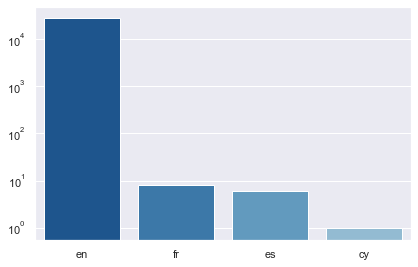

In [199]:
sns.set()
sns.set_palette('Blues_r')
fig, ax = plt.subplots()
ax.set_yscale('log')
sns.barplot(x=lang_distribution.index, y=lang_distribution.values, ax=ax)
plt.show()

In [63]:
covid_df[covid_df['language'] == 'fr']

,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count,language
9039,f0e3b4c1b91b2c741fe78f643644a2719f9b88e1,10.1016/j.annpat.2010.05.012,Que reste t-il de la microscopie électronique ...,Résumé Différentes méthodes complémentaires pe...,Electron microscopy; Human pathology; Surgical...,"Mari, Mireille; Hofman, Véronique; Butori, Cat...",Annales de Pathologie,362,1941,836,fr
13941,1fc5b87329af57d6bdbebf78dfb402791120a6ff,10.1093/heapol/czy102,Review of international efforts to strengthen ...,The 2014–16 West Africa Ebola epidemic was a w...,"On 18 March 2014, Médecins Sans Frontières ini...","Ravi, Sanjana J; Snyder, Michael R; Rivers, Ca...",Health Policy Plan,219,4350,1603,fr
15777,b565209d3d02d6defebda91d621eddbcd0a7611e,10.1016/j.vetpar.2018.12.009,Comparison of multiplexed-tandem real-time PCR...,Abstract Giardia intestinalis and Tritrichomon...,Giardia intestinalis and Tritrichomonas foetus...,"Meggiolaro, Maira N.; Roeber, Florian; Kobylsk...",Veterinary Parasitology,264,3805,1171,fr
16751,228de60eedef31b72a330186b75a7e8fa7aa8a74,10.1086/520600,Diagnostic Reverse-Transcription Polymerase Ch...,A network of European biosafety level 4 labora...,95% detection chance) were as follows: Zaire e...,"Panning, Marcus; Laue, Thomas; Ölschlager, Ste...",J Infect Dis,107,1897,900,fr


## Journal Contributions
Let's see what journal has published the most relevant research on COVID-19 and coronaviruses within this specific dataset!

Since we can only fit so many journals onto one bar plot, we're going to limit the journals we display to those that have contributed more than 100 articles to this dataset.

In [172]:
journal_dist = covid_df['journal'].value_counts()
above_100 = journal_dist[journal_dist.values > 100]
above_100

PLoS One                                               1517
Virology                                                675
Viruses                                                 548
Emerg Infect Dis                                        507
Arch Virol                                              489
Sci Rep                                                 438
Veterinary Microbiology                                 401
Virus Research                                          384
Virol J                                                 355
Journal of Virological Methods                          345
Vaccine                                                 311
PLoS Pathog                                             303
Antiviral Research                                      268
BMC Infect Dis                                          238
Front Immunol                                           211
Journal of Clinical Virology                            210
Front Microbiol                         

## Publish Date
Another thing we can inspect is when these 


In [216]:
from datetime import datetime

covid_df = pd.merge(covid_df, metadata_df[['sha', 'publish_time']], left_on='paper_id', right_on='sha', how='left')
covid_df['publish_time'] = pd.to_datetime(covid_df['publish_time'], infer_datetime_format=True)
covid_df

,paper_id,doi,title,abstract,body_text,authors,journal,abstract_word_count,body_word_count,body_unique_count,language,sha,publish_time
0,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,10.1080/14787210.2017.1271712,Update on therapeutic options for Middle East ...,Introduction: The Middle East Respiratory Synd...,The Middle East respiratory syndrome coronavir...,"Al-Tawfiq, Jaffar A.; Memish, Ziad A.",Expert Rev Anti Infect Ther,174,2748,996,en,4ed70c27f14b7f9e6219fe605eae2b21a229f23c,2016-12-24
1,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,10.1093/cid/ciaa256,A Novel Approach for a Novel Pathogen: using a...,Thousands of people in the United States have ...,"The 2019 novel coronavirus (SARS-CoV-2), ident...","Bryson-Cahn, Chloe; Duchin, Jeffrey; Makarewic...",Clin Infect Dis,50,944,486,en,306ef95a3a91e13a93bcc37fb2c509b67c0b5640,2020-03-12
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,10.1016/b978-0-12-800049-6.00293-6,Evolutionary Medicine IV. Evolution and Emerge...,Abstract This article discusses how evolutiona...,The evolutionary history of humans is characte...,"Scarpino, S.V.",Encyclopedia of Evolutionary Biology,72,2884,1091,en,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,2016-12-31
3,6599ebbef3d868afac9daa4f80fa075675cf03bc,10.1016/j.enpol.2008.08.029,International aviation emissions to 2025: Can ...,Abstract International aviation is growing rap...,"Sixty years ago, civil aviation was an infant ...","Macintosh, Andrew; Wallace, Lailey",Energy Policy,137,5838,1587,en,6599ebbef3d868afac9daa4f80fa075675cf03bc,2009-01-31
4,44290ff75bad8ffaf5d3028420739ce7b08dc2a9,10.1093/jac/dkp502,Inhibition of enterovirus 71 replication and t...,OBJECTIVES: Enterovirus 71 (EV71) causes serio...,Enteroviruses are members of the family Picorn...,"Hung, Hui-Chen; Chen, Tzu-Chun; Fang, Ming-Yu;...",J Antimicrob Chemother,260,3121,1064,en,44290ff75bad8ffaf5d3028420739ce7b08dc2a9,2010-01-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29024,228650bc0429064d800d4b9c5fb0e00c2533a579,10.1371/journal.pone.0215186,Lipidome profiles of postnatal day 2 vaginal s...,We hypothesized that postnatal development of ...,Early nutritional environment affects long ter...,"Harlow, KaLynn; Ferreira, Christina R.; Sobrei...",PLoS One,291,4139,1489,en,228650bc0429064d800d4b9c5fb0e00c2533a579,2019-09-26
29025,2246e28681bde69c65dc9081df367bb661997f19,10.1371/journal.pntd.0000690,"Secondary Syphilis in Cali, Colombia: New Conc...","Venereal syphilis is a multi-stage, sexually t...",Syphilis is a sexually transmitted disease (ST...,"Cruz, Adriana R.; Pillay, Allan; Zuluaga, Ana ...",PLoS Negl Trop Dis,419,5621,1976,en,2246e28681bde69c65dc9081df367bb661997f19,2010-05-18
29026,577c6a13f9ef70e9756890fc66e98f537c01ac0a,10.1038/srep21878,Replication and shedding of MERS-CoV in Jamaic...,The emergence of Middle East respiratory syndr...,Scientific RepoRts | 6:21878 | DOI: 10 .1038/s...,"Munster, Vincent J.; Adney, Danielle R.; van D...",Sci Rep,200,2832,1012,en,577c6a13f9ef70e9756890fc66e98f537c01ac0a,2016-02-22
29027,c5c2bc7a07670d6fb970d84a59aab3832752a3f1,10.3390/v10040199,Role of the ERK1/2 Signaling Pathway in the Re...,We have previously shown that the infection of...,Arenaviruses are enveloped RNA viruses contain...,"Brunetti, Jesús E.; Foscaldi, Sabrina; Quintan...",Viruses,210,4805,1522,en,c5c2bc7a07670d6fb970d84a59aab3832752a3f1,2018-04-17


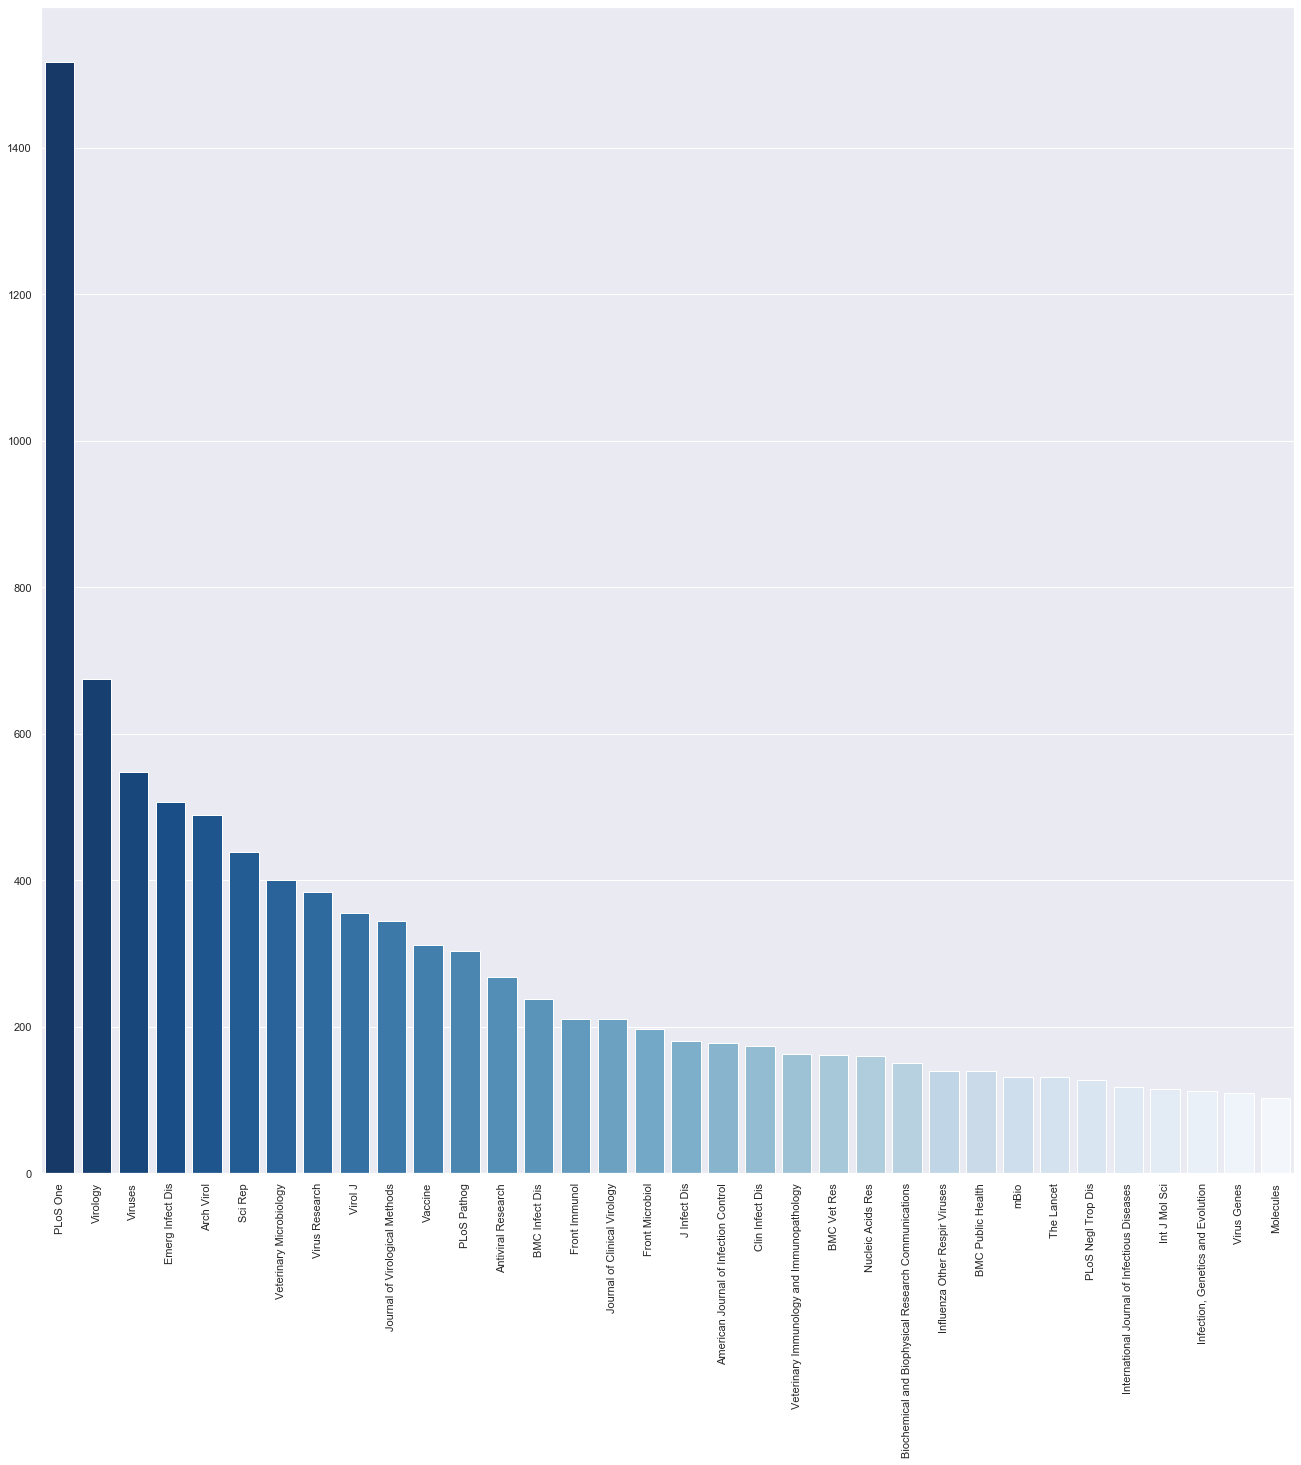

In [198]:
fig, ax_sized = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=90)
sns.barplot(x=above_100.index, y=above_100.values, ax=ax_sized, palette=sns.color_palette('Blues_r', len(above_100)))
plt.show()

# NLP + feature extraction
Now that we've successfully cleaned out the data and gotten all the text in a consistent fashion, now we're going to create a bag-of-words model and vectorize each of the documents! This'll then allow us to do some better visualization and run some cool ~ _machine learning_ ~ like PCA and t-SNE to both reduce dimensionality and visualize this better! 

In [44]:
covid_df = covid_df[covid_df['language'] == 'en'] # i.e. only select articles written in english, as it'll help parsing/NLP 

In [45]:
covid_df['language'].describe()

count     29025
unique        6
top          en
freq      29018
Name: language, dtype: object

In [46]:
# NLP analysis using Spacy
import spacy 
from space.lang.en.stop_words import STOP_WORDS

stop_words = STOP_WORDS
print(stop_words)

ModuleNotFoundError: No module named 'space'